## New SupCon sampler

In [18]:
from torch.utils.data import Dataset
from collections import defaultdict
import torch
import os
import numpy as np
import scanpy as sc
import random
from torch.utils.data import IterableDataset
from torch.utils.data import DataLoader
from plotnine import *
import pandas as pd

## Load the data

In [12]:
path = "/p/project1/hai_fzj_bda/koenig8/ot/data/"
adata_st = sc.read_h5ad(os.path.join(path, "adata_st.h5ad"))
adata_histo = sc.read_h5ad(os.path.join(path, "adata_histo.h5ad"))
adata_histo = adata_histo[adata_histo.obs.in_sample]
adata_st, adata_histo

(AnnData object with n_obs × n_vars = 50000 × 50
     obs: 'patch_id', 'brain_area', 'patchsize', 'x_st', 'y_st', 'z_st', 'brain_section_label', 'section', 'test_set', 'val_set', 'train_set'
     uns: 'neighbors', 'umap'
     obsm: 'X_umap', 'brain_area_onehot', 'brain_area_similarities', 'pca_embedding', 'pca_plus_slides', 'pca_plus_slides_scaled'
     obsp: 'connectivities', 'distances',
 View of AnnData object with n_obs × n_vars = 50000 × 1536
     obs: 'image_id', 'patchsize', 'center_ccf', 'pixel_coord', 'distance', 'nearest_ST', 'nearest_cell_id', 'target_atlas_plate', 'distance_new', 'x', 'y', 'z', 'x_st', 'y_st', 'z_st', 'image_nr', 'brain_area', 'group', 'slice', 'in_sample', 'test_set', 'val_set', 'train_set'
     obsm: 'brain_area_onehot', 'brain_area_similarities', 'uni_embedding', 'uni_pca_95', 'uni_pca_plus_coords')

## Dataset

In [74]:
class DualModalityDataset(Dataset):
    def __init__(self, embeddings_a, embeddings_b, labels_a, labels_b):
        self.embeddings_a = embeddings_a
        self.embeddings_b = embeddings_b
        self.labels_a = labels_a
        self.labels_b = labels_b

        self.class_to_indices_a = self._index(labels_a)
        self.class_to_indices_b = self._index(labels_b)
        self.classes = list(set(self.class_to_indices_a) | set(self.class_to_indices_b))

    def _index(self, labels):
        index = defaultdict(list)
        for i, label in enumerate(labels):
            index[int(label)].append(i)
        return index

    def get_class_samples(self, cls, k):
        a_idxs = self.class_to_indices_a.get(cls, [])
        b_idxs = self.class_to_indices_b.get(cls, [])

        a_sample = np.random.choice(a_idxs, min(k, len(a_idxs)), replace=False) if a_idxs else []
        b_sample = np.random.choice(b_idxs, min(k, len(b_idxs)), replace=False) if b_idxs else []

        return (
            torch.stack([self.embeddings_a[i] for i in a_sample]) if len(a_sample) > 0 else None,
            torch.stack([self.embeddings_b[i] for i in b_sample]) if len(b_sample) > 0 else None,
            [cls] * len(a_sample),
            [cls] * len(b_sample)
        )


In [94]:
class FixedQuotaSampler(IterableDataset):
    def __init__(self, dataset, class_skew_dict, C=10, K=50, total_samples=100_000, seed = 42):
        self.dataset = dataset
        self.class_skew_dict = class_skew_dict  # class_id -> number of samples per epoch
        self.C = C
        self.K = K
        self.minibatch = C * K
        self.total_samples = total_samples
        self.seed = seed
        self.shuffle_counter = 0
        self.rng = np.random.default_rng(seed)

        self._prepare_epoch_class_queue()

    def shuffle(self):
        self.shuffle_counter += 1
        self.rng = np.random.default_rng(self.seed + self.shuffle_counter)
        self._prepare_epoch_class_queue()

    def _prepare_epoch_class_queue(self):
        # Compute number of times each class must be used in batches
        classes = np.array(list(self.class_skew_dict.keys()))
        classes_to_index = {value: idx for idx, value in enumerate(classes)}
        class_counts = np.array(list(self.class_skew_dict.values()))
        print(classes)
        print(class_counts)
        print((class_counts > 0).sum())
        enough_classes_left = True
        class_queue = []

        while(enough_classes_left):            
            classes_i = self.rng.choice(
                classes, size = self.C, replace=False, p=class_counts/class_counts.sum(), shuffle=True
            )
            indices = np.array([classes_to_index[c] for c in classes_i])
            class_counts[indices] = np.maximum(class_counts[indices] - self.K * 2, 0)
            if (class_counts > 0).sum() < self.C:
                # Not enough values left to sample, finish the epoch
                enough_classes_left=False
            else:
                class_queue.append(classes_i)  # We get 2*K samples per class, K per modality

        self.class_queue = np.hstack(class_queue)

    def __iter__(self):
        for i in range(0, len(self.class_queue), self.C):
            selected = self.class_queue[i:self.C + i]
            assert np.unique(selected).size == selected.size

            a_batch, b_batch, a_labels, b_labels = [], [], [], []
            for cls in selected:
                a, b, a_lbl, b_lbl = self.dataset.get_class_samples(cls, self.K)
                if a is not None:
                    a_batch.append(a)
                    a_labels.extend(a_lbl)
                if b is not None:
                    b_batch.append(b)
                    b_labels.extend(b_lbl)

            yield {
                "a_batch": torch.cat(a_batch) if a_batch else torch.empty(0),
                "b_batch": torch.cat(b_batch) if b_batch else torch.empty(0),
                "a_classes": torch.tensor(a_labels),
                "b_classes": torch.tensor(b_labels)
            }

In [76]:
def redistribute_around_mean(arr, scale=0):
    arr = np.array(arr, dtype=np.float64)
    mean = np.mean(arr)
    total = np.sum(arr)

    # Compute how far each element is from the mean
    deviation = arr - mean

    # Apply scaling: higher deviations change more
    adjusted = arr - scale * deviation

    # Renormalize to match the original sum
    adjusted_sum = np.sum(adjusted)
    adjusted = adjusted * (total / adjusted_sum)
    adjusted = adjusted.astype(int)

    return adjusted

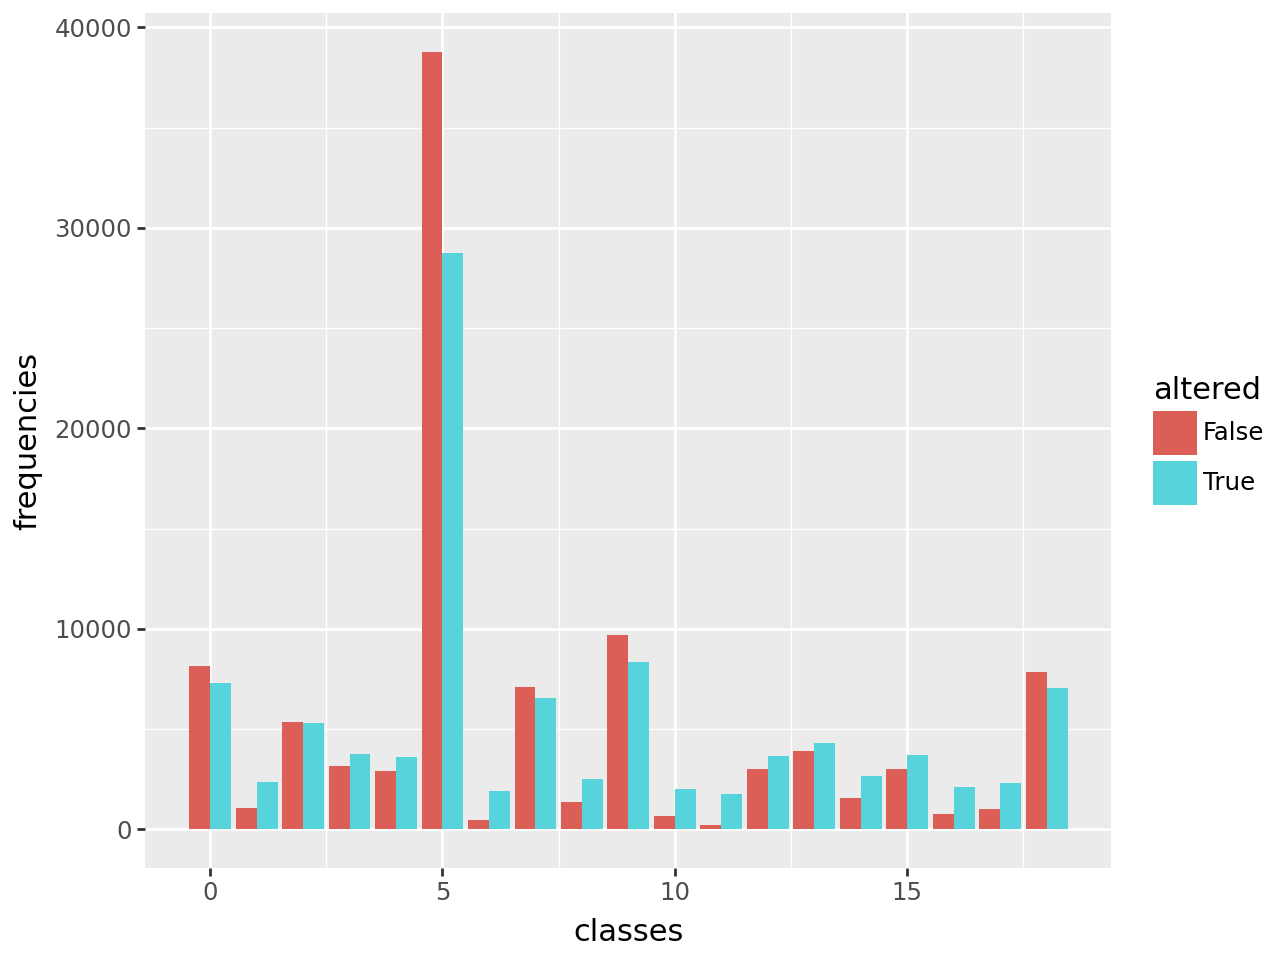

In [77]:
embeddings_a = torch.Tensor(adata_st.obsm["pca_embedding"])
labels_a = torch.Tensor(adata_st.obsm["brain_area_onehot"].toarray().nonzero()[-1])
embeddings_b = torch.Tensor(adata_histo.obsm["uni_pca_95"])
labels_b = torch.Tensor(adata_histo.obsm["brain_area_onehot"].toarray().nonzero()[-1])

classes, freqs = np.unique(np.hstack([labels_a.numpy(), labels_b.numpy()]), return_counts = True)
classes = classes.astype(int)
new_freqs = redistribute_around_mean(freqs, 0.3)
n = freqs.shape[0]

df_plot = pd.DataFrame(dict(
    classes = np.hstack((classes, classes)), 
    frequencies = np.hstack((freqs, new_freqs)), 
    altered = np.hstack((np.zeros(n), np.ones(n))).astype(bool) 
))
(ggplot(df_plot, aes(x = "classes", y = "frequencies", fill = "altered")) + 
geom_bar(stat="identity", position="dodge"))

In [103]:
freqs.sum()

np.int64(100000)

In [78]:
new_freqs.sum()

np.int64(99989)

#### Give whatevers missing to largest class

In [79]:
new_freqs[np.argmax(new_freqs)] += 11
new_freqs.sum()

np.int64(100000)

In [95]:
# Example skewed class histogram
class_counts = dict(zip(classes, new_freqs))

dataset = DualModalityDataset(embeddings_a, embeddings_b, labels_a, labels_b)
sampler = FixedQuotaSampler(dataset, class_skew_dict=class_counts, C=10, K=50)
loader = DataLoader(sampler, batch_size=None)


[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18]
[ 7295  2337  5316  3779  3629 28740  1907  6545  2518  8367  2031  1738
  3671  4309  2663  3685  2104  2302  7064]
19


In [96]:
n = 0
m = 0
for batch in loader:
    n += batch['a_classes'].shape[0] 
    m += batch['b_classes'].shape[0]
n, m

(34490, 35182)

In [97]:
for batch in loader:
    n = batch['a_classes'].shape[0]
    break
n

440

# Make sure that no class is present more than K times

In [98]:
for batch in loader:
    vals, counts = np.unique(batch['a_classes'].numpy(), return_counts=True)
    assert (counts <= 50).all()
    assert (counts > 1).all()

    vals, counts = np.unique(batch['b_classes'].numpy(), return_counts=True)
    assert (counts <= 50).all()
    assert (counts > 1).all()

## Seems to work, we know now that no class is present twice in the same batch and that all counts per class per batch are at least 1 

In [102]:
'try shuffling'
for batch in loader:
    classes_a = batch['a_classes']
    classes_b = batch['b_classes']
    break

sampler.shuffle()
for batch in loader:
    print(classes_a == batch['a_classes'])
    print(classes_b == batch['b_classes'])
    break

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18]
[ 7295  2337  5316  3779  3629 28740  1907  6545  2518  8367  2031  1738
  3671  4309  2663  3685  2104  2302  7064]
19


RuntimeError: The size of tensor a (440) must match the size of tensor b (470) at non-singleton dimension 0

==> works, only shuffling breaks the shapes